# K mean Algorithms

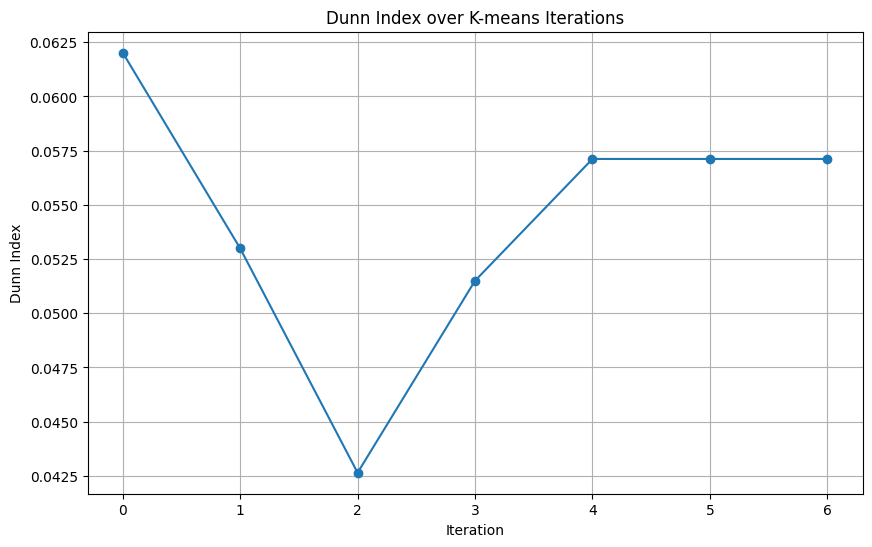

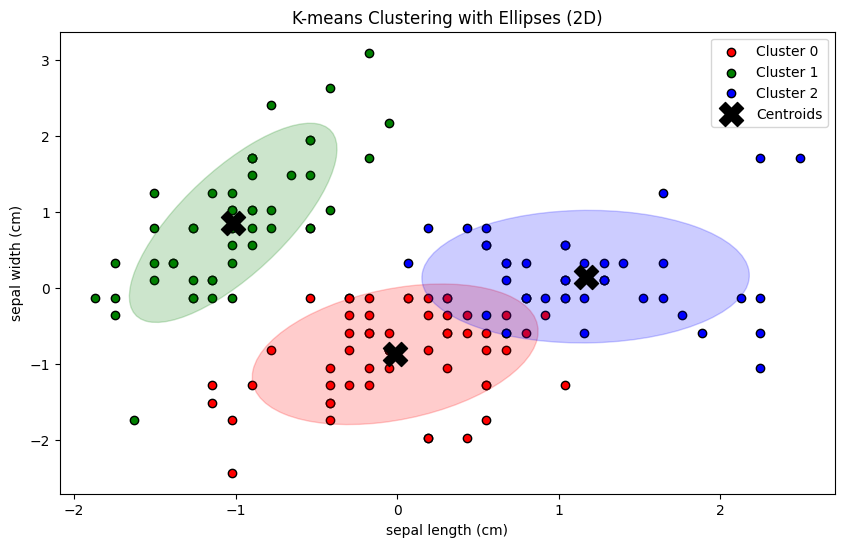

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse

# Load Iris dataset
iris = load_iris()
data = iris.data
features = iris.feature_names

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

def initialize_centroids(data, k):
    np.random.seed(42)
    random_indices = np.random.permutation(data.shape[0])
    centroids = data[random_indices[:k]]
    return centroids

def assign_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def dunn_index(data, labels):
    clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []
    
    # Calculate intra-cluster distances
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        if len(cluster_points) > 1:
            intra_dists.append(np.max(np.linalg.norm(cluster_points[:, np.newaxis] - cluster_points, axis=2)))
        else:
            intra_dists.append(0)
    
    # Calculate inter-cluster distances
    for i, cluster_i in enumerate(clusters):
        for j, cluster_j in enumerate(clusters):
            if i < j:
                points_i = data[labels == cluster_i]
                points_j = data[labels == cluster_j]
                inter_dists.append(np.min(np.linalg.norm(points_i[:, np.newaxis] - points_j, axis=2)))
    
    dunn = np.min(inter_dists) / np.max(intra_dists)
    return dunn

def kmeans_with_dunn(data, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(data, k)
    dunn_indices = []
    
    for i in range(max_iters):
        old_centroids = centroids
        labels = assign_clusters(data, centroids)
        centroids = update_centroids(data, labels, k)
        dunn = dunn_index(data, labels)
        dunn_indices.append(dunn)
        
        if np.all(np.abs(centroids - old_centroids) < tol):
            break
    
    return centroids, labels, dunn_indices

def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    vx, vy = eigenvectors[:, 0][0], eigenvectors[:, 0][1]
    theta = np.arctan2(vy, vx)
    theta = np.degrees(theta)
    
    # Width and height of the ellipse
    width, height = 3 * np.sqrt(eigenvalues[:2])
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, color=color, alpha=0.2)
    ax.add_patch(ellipse)


def plot_clusters_with_ellipses(data, labels, centroids):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    unique_labels = np.unique(labels)
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    
    for i, label in enumerate(unique_labels):
        cluster_points = data[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], marker='o', edgecolor='k', label=f'Cluster {label}')
        
        # Calculate the mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        
        # Plot the ellipse
        plot_ellipse(ax, mean, cov, colors[i])
    
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', edgecolor='k', label='Centroids')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('K-means Clustering with Ellipses (2D)')
    plt.legend()
    plt.show()

# Apply K-means Clustering
k = 3
centroids, labels, dunn_indices = kmeans_with_dunn(data_scaled, k)

# Plot Dunn Index over iterations
plt.figure(figsize=(10, 6))
plt.plot(dunn_indices, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Dunn Index')
plt.title('Dunn Index over K-means Iterations')
plt.grid(True)
plt.show()

# Plot clusters with ellipses
plot_clusters_with_ellipses(data_scaled, labels, centroids)


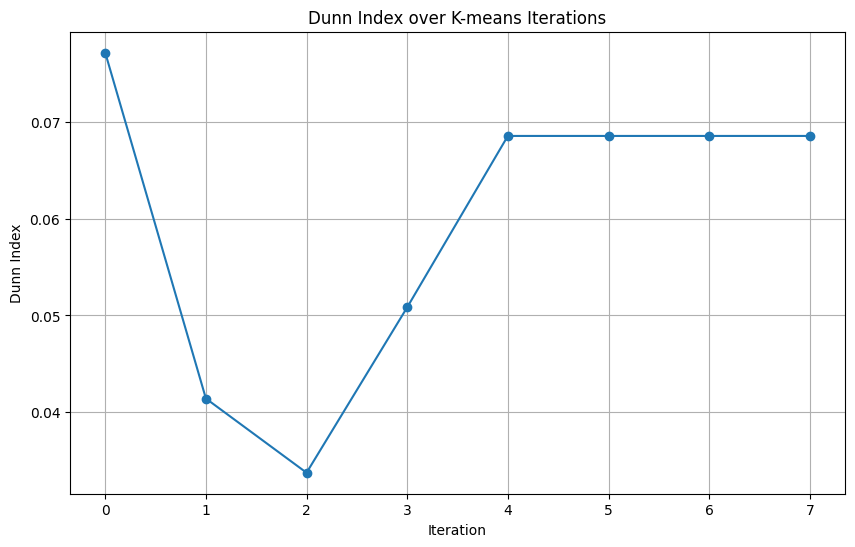

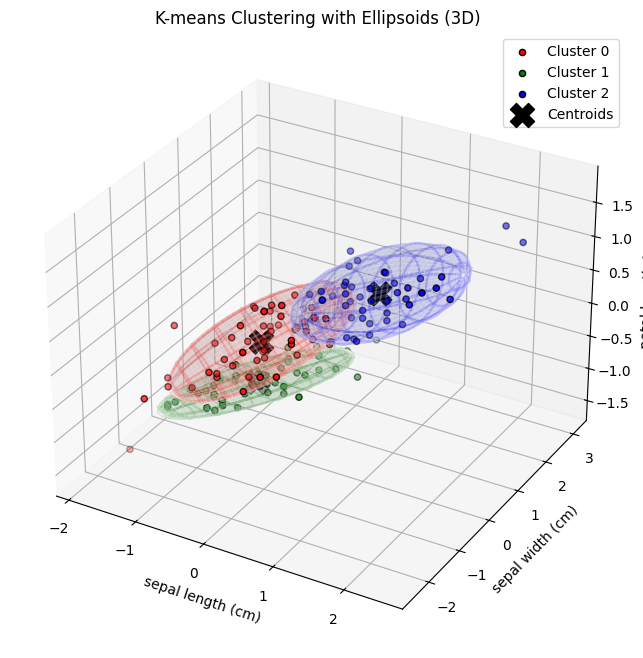

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load Iris dataset
iris = load_iris()
data = iris.data
features = iris.feature_names

# Use the first three features for 3D visualization
data_3d = data[:, :3]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_3d)


def plot_ellipsoid(ax, mean, cov, color):
    # Create a grid of points for the ellipsoid
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Perform eigen-decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Normalize eigenvectors and eigenvalues
    radii = np.sqrt(eigenvalues)
    radii = 2 * radii  # For visual scaling
    
    # Create ellipsoid points in the original space
    ellipsoid = np.dot(np.column_stack((x.flatten(), y.flatten(), z.flatten())), np.diag(radii)).dot(eigenvectors.T)
    ellipsoid += mean
    
    # Reshape for plotting
    x, y, z = ellipsoid[:, 0].reshape(x.shape), ellipsoid[:, 1].reshape(y.shape), ellipsoid[:, 2].reshape(z.shape)
    
    # Plot the surface
    ax.plot_surface(x, y, z, color=color, alpha=0.1, edgecolor='w')

    # Optionally add wireframe for better visibility
    ax.plot_wireframe(x, y, z, color=color, rstride=10, cstride=10, alpha=0.3)


def plot_clusters_with_ellipsoids(data, labels, centroids):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    for i, label in enumerate(unique_labels):
        cluster_points = data[labels == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c=colors[i], marker='o', edgecolor='k', label=f'Cluster {label}')

        # Calculate the mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)

        # Plot the ellipsoid
        plot_ellipsoid(ax, mean, cov, colors[i])

    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=300, c='black', marker='X', edgecolor='k', label='Centroids')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.set_title('K-means Clustering with Ellipsoids (3D)')
    ax.legend()
    plt.show()

# Apply K-means Clustering
k = 3
centroids, labels, dunn_indices = kmeans_with_dunn(data_scaled, k)

# Plot Dunn Index over iterations
plt.figure(figsize=(10, 6))
plt.plot(dunn_indices, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Dunn Index')
plt.title('Dunn Index over K-means Iterations')
plt.grid(True)
plt.show()

# Plot clusters with ellipsoids
plot_clusters_with_ellipsoids(data_scaled, labels, centroids)


# K-mean++ Algorithms

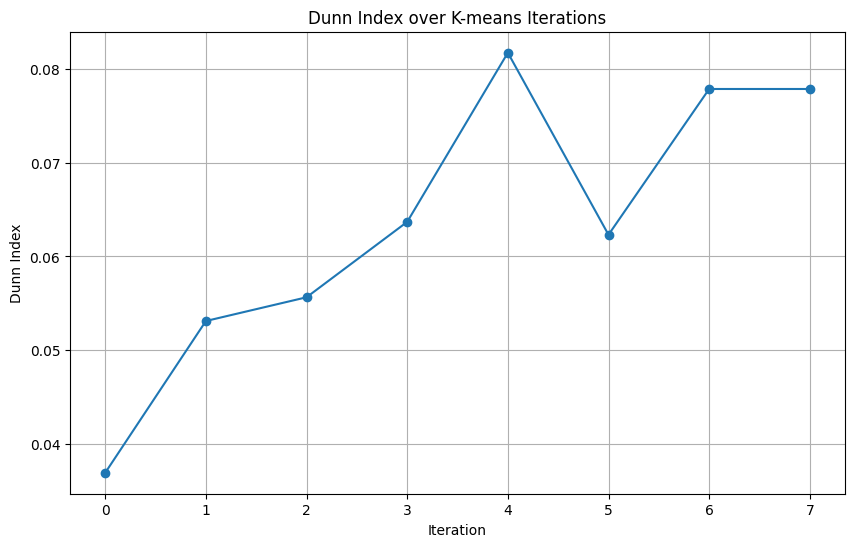

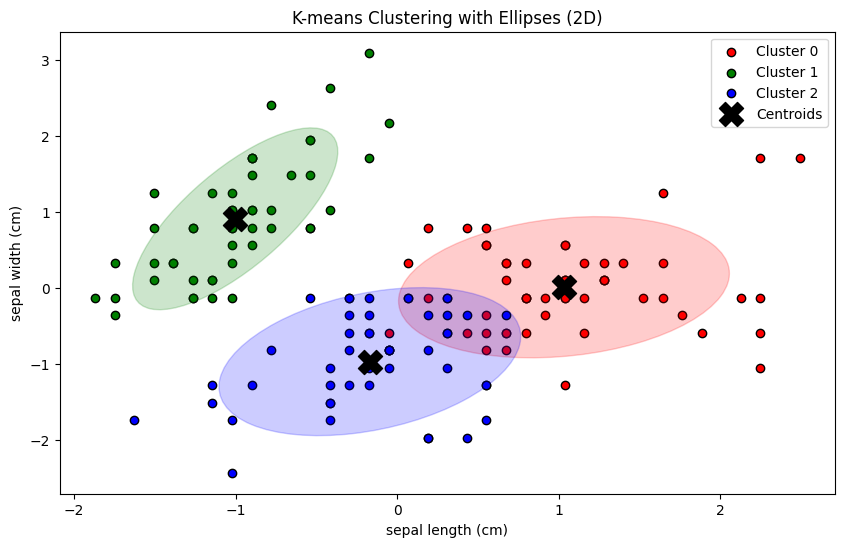

In [8]:
# Load Iris dataset
iris = load_iris()
data = iris.data
features = iris.feature_names

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

def initialize_centroids_kmeans_pp(data, k):
    n_samples, n_features = data.shape
    centroids = np.zeros((k, n_features))
    
    # Step 1: Choose the first centroid randomly
    centroids[0] = data[np.random.randint(n_samples)]
    
    # Step 2-4: Choose remaining k-1 centroids
    for i in range(1, k):
        # Compute the distance from each point to the nearest centroid
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - centroids[np.newaxis, :i], axis=2), axis=1)
        squared_distances = distances ** 2
        
        # Select the next centroid with probability proportional to D(x)^2
        probabilities = squared_distances / np.sum(squared_distances)
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        
        next_centroid_index = np.where(cumulative_probabilities >= r)[0][0]
        centroids[i] = data[next_centroid_index]
    
    return centroids

def assign_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def dunn_index(data, labels):
    clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []
    
    # Calculate intra-cluster distances
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        if len(cluster_points) > 1:
            intra_dists.append(np.max(np.linalg.norm(cluster_points[:, np.newaxis] - cluster_points, axis=2)))
        else:
            intra_dists.append(0)
    
    # Calculate inter-cluster distances
    for i, cluster_i in enumerate(clusters):
        for j, cluster_j in enumerate(clusters):
            if i < j:
                points_i = data[labels == cluster_i]
                points_j = data[labels == cluster_j]
                inter_dists.append(np.min(np.linalg.norm(points_i[:, np.newaxis] - points_j, axis=2)))
    
    dunn = np.min(inter_dists) / np.max(intra_dists)
    return dunn

def kmeans_with_dunn(data, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids_kmeans_pp(data, k)
    dunn_indices = []
    
    for i in range(max_iters):
        old_centroids = centroids
        labels = assign_clusters(data, centroids)
        centroids = update_centroids(data, labels, k)
        dunn = dunn_index(data, labels)
        dunn_indices.append(dunn)
        
        if np.all(np.abs(centroids - old_centroids) < tol):
            break
    
    return centroids, labels, dunn_indices

def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    vx, vy = eigenvectors[:, 0][0], eigenvectors[:, 0][1]
    theta = np.arctan2(vy, vx)
    theta = np.degrees(theta)
    
    # Width and height of the ellipse
    width, height = 3 * np.sqrt(eigenvalues[:2])
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, color=color, alpha=0.2)
    ax.add_patch(ellipse)


def plot_clusters_with_ellipses(data, labels, centroids):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    unique_labels = np.unique(labels)
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    
    for i, label in enumerate(unique_labels):
        cluster_points = data[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], marker='o', edgecolor='k', label=f'Cluster {label}')
        
        # Calculate the mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        
        # Plot the ellipse
        plot_ellipse(ax, mean, cov, colors[i])
    
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', edgecolor='k', label='Centroids')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('K-means Clustering with Ellipses (2D)')
    plt.legend()
    plt.show()

# Apply K-means Clustering
k = 3
centroids, labels, dunn_indices = kmeans_with_dunn(data_scaled, k)

# Plot Dunn Index over iterations
plt.figure(figsize=(10, 6))
plt.plot(dunn_indices, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Dunn Index')
plt.title('Dunn Index over K-means Iterations')
plt.grid(True)
plt.show()

# Plot clusters with ellipses
plot_clusters_with_ellipses(data_scaled, labels, centroids)

# K-medoids Algorithms

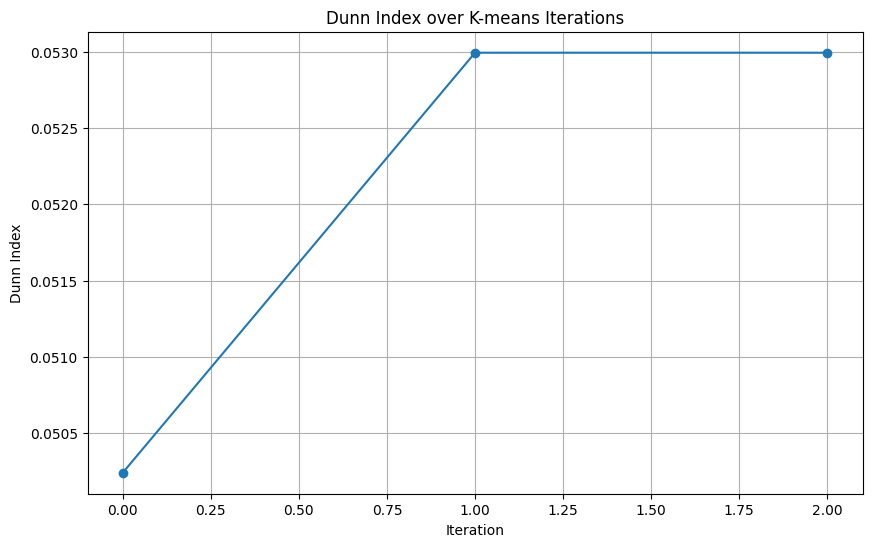

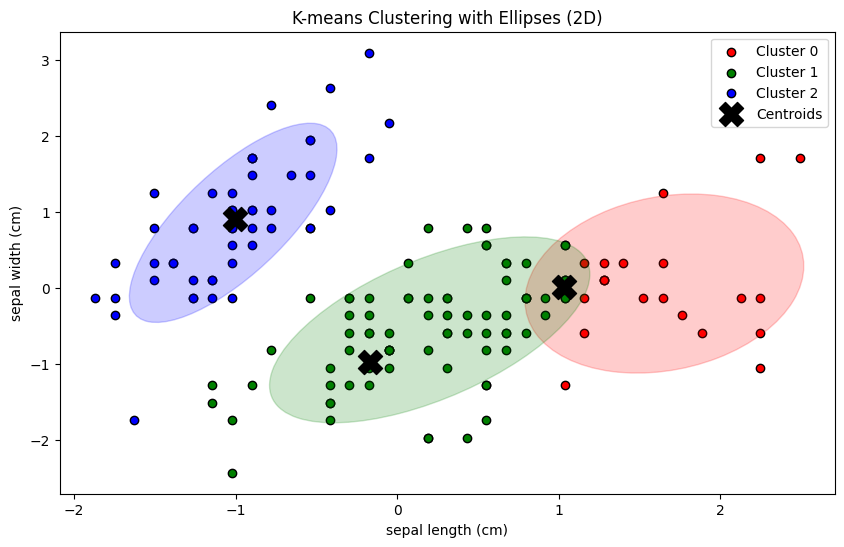

In [15]:
# Load Iris dataset
iris = load_iris()
data = iris.data
features = iris.feature_names

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

def initialize_medoids(data, k):
    n_samples = data.shape[0]
    init_indices = np.random.choice(n_samples, k, replace=False)
    return data[init_indices]

def assign_clusters_medoids(data, medoids):
    distances = pairwise_distances_argmin_min(data, medoids, metric='euclidean')
    return distances[0]

def update_medoids(data, labels, k):
    medoids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[labels == i]
        medoid_index = np.argmin(np.sum(pairwise_distances_argmin_min(cluster_points, cluster_points, metric='euclidean')[1]))
        medoids[i] = cluster_points[medoid_index]
    return medoids

def calculate_cost(data, labels, medoids):
    cost = 0
    for i, medoid in enumerate(medoids):
        cost += np.sum(pairwise_distances_argmin_min(data[labels == i], [medoid], metric='euclidean')[1])
    return cost

def kmedoids(data, k, max_iters=100):
    dunn_indices = []
    medoids = initialize_medoids(data, k)
    labels = assign_clusters_medoids(data, medoids)
    old_cost = calculate_cost(data, labels, medoids)
    dunn = dunn_index(data, labels)
    dunn_indices.append(dunn)
    
    
    for _ in range(max_iters):
        new_medoids = update_medoids(data, labels, k)
        new_labels = assign_clusters_medoids(data, new_medoids)
        new_cost = calculate_cost(data, new_labels, new_medoids)
        dunn = dunn_index(data, new_labels)
        dunn_indices.append(dunn)
        
        if new_cost < old_cost:
            medoids = new_medoids
            labels = new_labels
            old_cost = new_cost
        else:
            break
    
    return medoids, labels , dunn_indices

# Apply K-medoids clustering
k = 3
medoids, labels, dunn_indices = kmedoids(data_scaled, k)

# Plot Dunn Index over iterations
plt.figure(figsize=(10, 6))
plt.plot(dunn_indices, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Dunn Index')
plt.title('Dunn Index over K-means Iterations')
plt.grid(True)
plt.show()

# Plot clusters with ellipses
plot_clusters_with_ellipses(data_scaled, labels, centroids)

